In [1]:
% matplotlib inline

import sys

sys.path.insert(0, "..")

import time
import pandas as pd

from IPython import display as d

import numpy as np

import seaborn as sns
sns.set()

from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier

from libs import container
from libs.experiment import (
    WithAnotherExperiment, KFoldExperiment, roc, 
    discretize_classes, clean_features)

import pytff


from libs import fourier_help

from matplotlib import pyplot as plt
from matplotlib import cm
import seaborn as sns
sns.set()

plt.rcParams['figure.figsize'] = (10, 6)

In [2]:
path = "/home/data/carpyncho/stored/samples/smp_2500_rrVSunk/"
data = container.read(path)
_, classes, sclasses = discretize_classes(data)
cls_name = {v:k for k, v in classes.items()}
df = data.b278

ogle3 = pd.read_table("/home/jbcabral/projects/paper_b278/src/legacy/data/ogle_rr.txt", header=6)
ogle3.columns

tile = pd.DataFrame(np.load("/home/data/carpyncho/stored/npy_tiles/cat_b278_jhk_1.npy"))

def get_o3id(o3id):
    return ogle3[ogle3["# ID"] == o3id].A_1.values[0]
    
df = df[df.scls == 3].copy()
df["ogle3_id"] = df.id.apply(lambda cid: tile[tile.id == cid].ogle3_id.values[0])
df["ogle3_A"] = df.ogle3_id.apply(get_o3id)
df["Feat A vs Feat. Fourier A0"] = np.abs(df.Amplitude - df.Freq1_harmonics_amplitude_0)
df["Feat A vs OGLE3 A_1"] = np.abs(df.Amplitude - df.ogle3_A)
df["Feat Fourier A0 vs OGLE3 A_1"] = np.abs(df.ogle3_A - df.Freq1_harmonics_amplitude_0)


obs = pd.read_pickle("/home/jbcabral/projects/paper_b278/src/legacy/data/rrb278_obs.pkl")

Loading '/home/data/carpyncho/stored/samples/smp_2500_rrVSunk/b261.npy'...
Loading '/home/data/carpyncho/stored/samples/smp_2500_rrVSunk/b263.npy'...
Loading '/home/data/carpyncho/stored/samples/smp_2500_rrVSunk/b264.npy'...
Loading '/home/data/carpyncho/stored/samples/smp_2500_rrVSunk/b262.npy'...
Loading '/home/data/carpyncho/stored/samples/smp_2500_rrVSunk/b278.npy'...


/home/jbcabral/projects/paper_b278/local/lib/python2.7/site-packages/IPython/core/interactiveshell.py:2718: DtypeWarning: Columns (26) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


In [3]:
columns = [
    'Feat A vs Feat. Fourier A0', 
    'Feat A vs OGLE3 A_1', 
    'Feat Fourier A0 vs OGLE3 A_1'
]

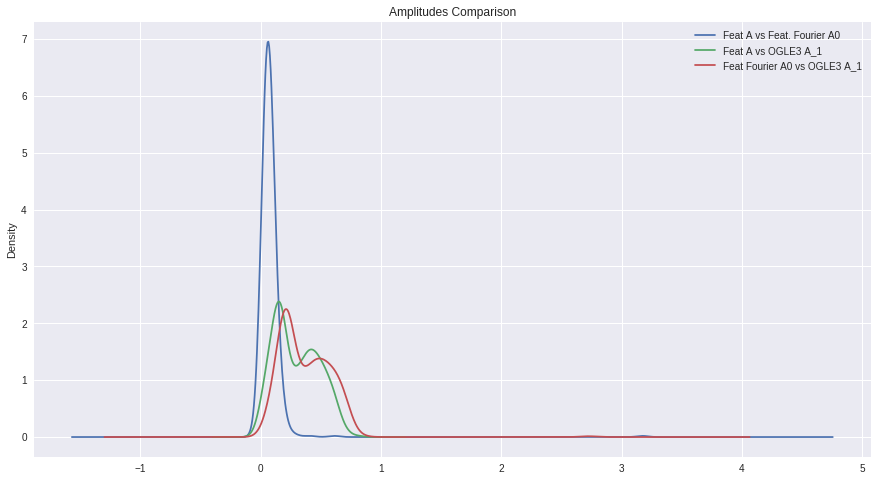

In [4]:
plt.rcParams['figure.figsize'] = (15, 8)
ax = df[columns].plot.kde(title="Amplitudes Comparison");

6 RRLyr-RRab


,Feat A vs OGLE3 A_1,Feat Fourier A0 vs OGLE3 A_1
count,287.000000,287.000000
mean,0.377167,0.455720
std,0.168161,0.222165
min,0.007500,0.050200
25%,0.272375,0.331971
50%,0.395750,0.462044
75%,0.502375,0.589256
max,0.803250,2.723283


7 RRLyr-RRc


,Feat A vs OGLE3 A_1,Feat Fourier A0 vs OGLE3 A_1
count,133.000000,133.000000
mean,0.131838,0.199119
std,0.056008,0.047791
min,0.001000,0.041795
25%,0.097000,0.178588
50%,0.145000,0.208662
75%,0.172000,0.230130
max,0.314500,0.346921


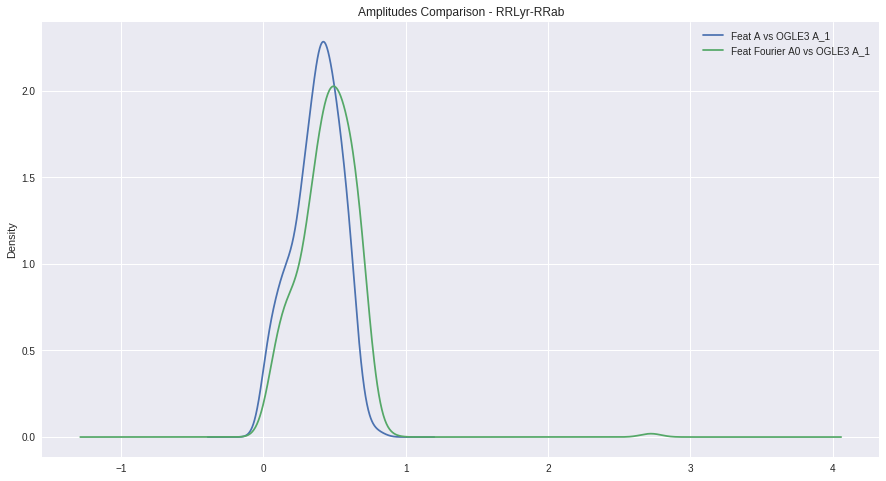

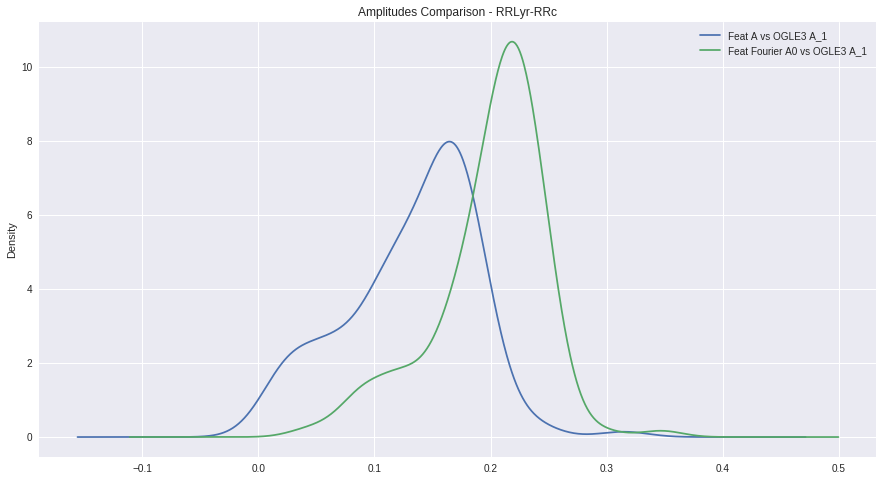

In [8]:
for cls in set(df.cls):           
    if cls == 8:
        continue
    print cls, cls_name[cls]
    cosos = df[df.cls==cls][columns[1:]]
    cosos.plot.kde(title="Amplitudes Comparison - " + cls_name[cls]);
    plt.plot();
    d.display(cosos.describe())
#     df[df.cls==cls][columns].plot.kde(title="Amplitudes Comparison " + cls_name[cls], ax=ax);